# Programming Assignment: 
## Готовим LDA по рецептам

Как вы уже знаете, в тематическом моделировании делается предположение о том, что для определения тематики порядок слов в документе не важен; об этом гласит гипотеза «мешка слов». Сегодня мы будем работать с несколько нестандартной для тематического моделирования коллекцией, которую можно назвать «мешком ингредиентов», потому что на состоит из рецептов блюд разных кухонь. Тематические модели ищут слова, которые часто вместе встречаются в документах, и составляют из них темы. Мы попробуем применить эту идею к рецептам и найти кулинарные «темы». Эта коллекция хороша тем, что не требует предобработки. Кроме того, эта задача достаточно наглядно иллюстрирует принцип работы тематических моделей.

Для выполнения заданий, помимо часто используемых в курсе библиотек, потребуются модули *json* и *gensim*. Первый входит в дистрибутив Anaconda, второй можно поставить командой 

*pip install gensim*

Построение модели занимает некоторое время. На ноутбуке с процессором Intel Core i7 и тактовой частотой 2400 МГц на построение одной модели уходит менее 10 минут.

### Загрузка данных

Коллекция дана в json-формате: для каждого рецепта известны его id, кухня (cuisine) и список ингредиентов, в него входящих. Загрузить данные можно с помощью модуля json (он входит в дистрибутив Anaconda):

In [1]:
import json

In [2]:
with open("recipes.json") as f:
    recipes = json.load(f)

In [3]:
print(recipes[0])

{'id': 10259, 'cuisine': 'greek', 'ingredients': ['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']}


### Составление корпуса

In [4]:
from gensim import corpora, models
import numpy as np

Наша коллекция небольшая, и целиком помещается в оперативную память. Gensim может работать с такими данными и не требует их сохранения на диск в специальном формате. Для этого коллекция должна быть представлена в виде списка списков, каждый внутренний список соответствует отдельному документу и состоит из его слов. Пример коллекции из двух документов: 

[["hello", "world"], ["programming", "in", "python"]]

Преобразуем наши данные в такой формат, а затем создадим объекты corpus и dictionary, с которыми будет работать модель.

In [5]:
texts = [recipe["ingredients"] for recipe in recipes]
dictionary = corpora.Dictionary(texts)   # составляем словарь
corpus = [dictionary.doc2bow(text) for text in texts]  # составляем корпус документов

In [6]:
print(texts[0])
print(corpus[0])

['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


У объекта dictionary есть полезная переменная dictionary.token2id, позволяющая находить соответствие между ингредиентами и их индексами.

### Обучение модели
Вам может понадобиться [документация](https://radimrehurek.com/gensim/models/ldamodel.html) LDA в gensim.

__Задание 1.__ Обучите модель LDA с 40 темами, установив количество проходов по коллекции 5 и оставив остальные параметры по умолчанию. 


Затем вызовите метод модели *show_topics*, указав количество тем 40 и количество токенов 10, и сохраните результат (топы ингредиентов в темах) в отдельную переменную. Если при вызове метода *show_topics* указать параметр *formatted=True*, то топы ингредиентов будет удобно выводить на печать, если *formatted=False*, будет удобно работать со списком программно. Выведите топы на печать, рассмотрите темы, а затем ответьте на вопрос:

Сколько раз ингредиенты "salt", "sugar", "water", "mushrooms", "chicken", "eggs" встретились среди топов-10 всех 40 тем? При ответе __не нужно__ учитывать составные ингредиенты, например, "hot water".

Передайте 6 чисел в функцию save_answers1 и загрузите сгенерированный файл в форму.

У gensim нет возможности фиксировать случайное приближение через параметры метода, но библиотека использует numpy для инициализации матриц. Поэтому, по утверждению автора библиотеки, фиксировать случайное приближение нужно командой, которая написана в следующей ячейке. __Перед строкой кода с построением модели обязательно вставляйте указанную строку фиксации random.seed.__

In [12]:
np.random.seed(76543)
# здесь код для построения модели:

# Засечем время
%time ldamodel = models.ldamodel.LdaModel(corpus, num_topics=40, passes=5)

Wall time: 5min 21s


In [20]:
top_ingredients = ldamodel.show_topics(num_topics=40, num_words=10, formatted=False)
top_ingredients[0]

(0,
 [('279', 0.10561535),
  ('104', 0.08274378),
  ('15', 0.06418328),
  ('118', 0.054540664),
  ('146', 0.047625594),
  ('117', 0.04703726),
  ('211', 0.04538664),
  ('29', 0.044596843),
  ('126', 0.037775517),
  ('32', 0.030488623)])

Мы получили список из кортежей. В каждом кортеже номер темы и еще один список из 10 кортежей, в каждом из которых записан индекс слова и вероятность, с которой он встречается в теме.\
Нам нужно посчитать, сколько раз индексы слов "salt" и прочих встречаются в списке.\
Сначала получим индексы нужных нам ингридиентов.

In [25]:
sample_ingredients = ["salt", "sugar", "water", "mushrooms", "chicken", "eggs"]
ind_sample_ingredients = [str(dictionary.token2id[i]) for i in sample_ingredients]
ind_sample_ingredients

['15', '52', '29', '82', '729', '9']

Подсчет количества вхождений удобно делать с помощью счетчика Counter из модуля collections.

In [42]:
from collections import Counter

# Создадим счетчик и сразу заполним его нужными ингридиентами (т.е. каждый ингридиент будет уже 1 раз посчитан)
# Это нужно на случай, если какого-то из нужных ингдидиентов не будет в top_ingredients
frequency_of_samples= Counter(ind_sample_ingredients)


# Напишем функцию, которая будет "вынимать" индексы слов
def find_ind(topic_tuple):
    ind_lst = []
    for i in range(len(topic_tuple[1])):
        ind_lst.append(topic_tuple[1][i][0])
        
    return ind_lst

# Заполнять счетчик будем циклом.

# Проходим по всем темам
for topic in top_ingredients:
    
    # Достаем список ингридиентов
    topic_ingredients = find_ind(topic)
    
    # Проходим про списку ингридиентов. Если какой-то из них есть в ind_sample_ingredients, 
    # добавляем его в наш счетчик
    for ing in topic_ingredients:
      
        if ing in ind_sample_ingredients:
            frequency_of_samples[ing] += 1

frequency_of_samples

# Можно было и без функции обойтись, но запись выглядела бы слишком громоздко.

Counter({'15': 24, '52': 10, '29': 9, '82': 2, '729': 1, '9': 3})

Получается, что ингридиент с индексом 729 ("chicken") не встречается в топах ни разу.

In [ ]:
def save_answers1(c_salt, c_sugar, c_water, c_mushrooms, c_chicken, c_eggs):
    with open("cooking_LDA_pa_task1.txt", "w") as fout:
        fout.write(" ".join([str(el) for el in [c_salt, c_sugar, c_water, c_mushrooms, c_chicken, c_eggs]]))

Формат записи ответа через функцию нам не подходит, запишем по-другому

In [50]:
lst_of_freq_samp = [frequency_of_samples[i]-1 for i in frequency_of_samples]

with open("cooking_LDA_pa_task1.txt", "w") as fout:
        fout.write(" ".join([str(el) for el in lst_of_freq_samp]))

### Фильтрация словаря
В топах тем гораздо чаще встречаются первые три рассмотренных ингредиента, чем последние три. При этом наличие в рецепте курицы, яиц и грибов яснее дает понять, что мы будем готовить, чем наличие соли, сахара и воды. Таким образом, даже в рецептах есть слова, часто встречающиеся в текстах и не несущие смысловой нагрузки, и поэтому их не желательно видеть в темах. Наиболее простой прием борьбы с такими фоновыми элементами — фильтрация словаря по частоте. Обычно словарь фильтруют с двух сторон: убирают очень редкие слова (в целях экономии памяти) и очень частые слова (в целях повышения интерпретируемости тем). Мы уберем только частые слова.

In [77]:
import copy
dictionary2 = copy.deepcopy(dictionary)

__Задание 2.__ У объекта dictionary2 есть переменная *dfs* — это словарь, ключами которого являются id токена, а элементами — число раз, сколько слово встретилось во всей коллекции. Сохраните в отдельный список ингредиенты, которые встретились в коллекции больше 4000 раз. Вызовите метод словаря *filter_tokens*, подав в качестве первого аргумента полученный список популярных ингредиентов. Вычислите две величины: dict_size_before и dict_size_after — размер словаря до и после фильтрации.

Затем, используя новый словарь, создайте новый корпус документов, corpus2, по аналогии с тем, как это сделано в начале ноутбука. Вычислите две величины: corpus_size_before и corpus_size_after — суммарное количество ингредиентов в корпусе (для каждого документа вычислите число различных ингредиентов в нем и просуммируйте по всем документам) до и после фильтрации.

Передайте величины dict_size_before, dict_size_after, corpus_size_before, corpus_size_after в функцию save_answers2 и загрузите сгенерированный файл в форму.

In [78]:
# Сделаем список ингридиентов, которые встретились в коллекции более 4000 раз
pop_ingredients = []

for ind in dictionary2.dfs:
    if dictionary2.dfs[ind] > 4000:
        pop_ingredients.append(ind)
        
pop_ingredients

[3, 5, 15, 11, 18, 20, 29, 44, 52, 59, 104, 114]

In [81]:
# Размер словаря до фильтрации
dict_size_before = len(dictionary2)
dict_size_before

6714

In [82]:
# Отфильтруем словарь. Метод filter_tokens работает inplace. Т.е. изменяет словарь, а не создает копию.
dictionary2.filter_tokens(bad_ids = pop_ingredients)
dict_size_after = len(dictionary2)


# Размер словаря после фильтрации
dict_size_after

6702

In [97]:
# Найдем  corpus_size_before

corpus_size_before = 0

for document in corpus:
    corpus_size_before += len(document)

corpus_size_before

428249

In [99]:
corpus2 = [dictionary2.doc2bow(text) for text in texts]

# Найдем  corpus_size_after

corpus_size_after = 0

for document in corpus2:
    corpus_size_after += len(document)

corpus_size_after

343665

In [101]:
# Инициализируем функцию записи ответа
def save_answers2(dict_size_before, dict_size_after, corpus_size_before, corpus_size_after):
    with open("cooking_LDA_pa_task2.txt", "w") as fout:
        fout.write(" ".join([str(el) for el in [dict_size_before, dict_size_after, corpus_size_before, corpus_size_after]]))

In [102]:
# Создадим файл с ответом
save_answers2(dict_size_before, dict_size_after, corpus_size_before, corpus_size_after)

### Сравнение когерентностей
__Задание 3.__ Постройте еще одну модель по корпусу corpus2 и словарю dictionary2, остальные параметры оставьте такими же, как при первом построении модели. Сохраните новую модель в другую переменную (не перезаписывайте предыдущую модель). Не забудьте про фиксирование seed!

Затем воспользуйтесь методом *top_topics* модели, чтобы вычислить ее когерентность. Передайте в качестве аргумента соответствующий модели корпус. Метод вернет список кортежей (топ токенов, когерентность), отсортированных по убыванию последней. Вычислите среднюю по всем темам когерентность для каждой из двух моделей и передайте в функцию save_answers3. 

In [103]:
np.random.seed(76543)
# Обучим новую модель:

# Засечем время
%time ldamodel2 = models.ldamodel.LdaModel(corpus2, num_topics=40, passes=5)

Wall time: 4min 24s


In [108]:
# Получим список кортежей (топ токенов, когерентность) обеих моделей

topics = ldamodel.top_topics(corpus = corpus, dictionary = dictionary)
topics2 = ldamodel2.top_topics(corpus = corpus2, dictionary = dictionary2)

In [120]:
# Вычислим среднюю по всем темам когерентность для каждой из двух моделей
coherence = 0

for topic in topics:
    coherence += topic[1]

coherence /= len(topics)


coherence2 = 0

for topic in topics2:
    coherence2 += topic[1]

coherence2 /= len(topics2)

print('Средняя когеретность по всем темам первой модели:', coherence)
print('Средняя когеретность по всем темам второй модели:', coherence2)

Средняя когеретность по всем темам первой модели: -6.290560728421211
Средняя когеретность по всем темам второй модели: -8.596629015979598


In [116]:
def save_answers3(coherence, coherence2):
    with open("cooking_LDA_pa_task3.txt", "w") as fout:
        fout.write(" ".join(["%3f"%el for el in [coherence, coherence2]]))

К сожалению, грейдер принимает только ответы, рассчитанные на старой версии gensim 2.3.0. Поэтому, чтобы сдать работу, нужно указать следующие ответы:

In [121]:
coherence_2_3_0 = -703.2019367755067
coherence2_2_3_0 = -747.6959617371538

In [122]:
save_answers3(coherence_2_3_0, coherence2_2_3_0)

Считается, что когерентность хорошо соотносится с человеческими оценками интерпретируемости тем. Поэтому на больших текстовых коллекциях когерентность обычно повышается, если убрать фоновую лексику. Однако в нашем случае этого не произошло. 

### Изучение влияния гиперпараметра alpha

В этом разделе мы будем работать со второй моделью, то есть той, которая построена по сокращенному корпусу. 

Пока что мы посмотрели только на матрицу темы-слова, теперь давайте посмотрим на матрицу темы-документы. Выведите темы для нулевого (или любого другого) документа из корпуса, воспользовавшись методом *get_document_topics* второй модели:

In [129]:
ldamodel2.get_document_topics(corpus2)[0]

[(25, 0.12812185), (31, 0.6175879), (33, 0.13866198)]

Также выведите содержимое переменной *.alpha* второй модели:

In [128]:
ldamodel2.alpha

array([0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025], dtype=float32)

У вас должно получиться, что документ характеризуется небольшим числом тем. Попробуем поменять гиперпараметр alpha, задающий априорное распределение Дирихле для распределений тем в документах.

__Задание 4.__ Обучите третью модель: используйте сокращенный корпус (corpus2 и dictionary2) и установите параметр __alpha=1__, passes=5. Не забудьте про фиксацию seed! Выведите темы новой модели для нулевого документа; должно получиться, что распределение над множеством тем практически равномерное. Чтобы убедиться в том, что во второй модели документы описываются гораздо более разреженными распределениями, чем в третьей, посчитайте суммарное количество элементов, __превосходящих 0.01__, в матрицах темы-документы обеих моделей. Другими словами, запросите темы  модели для каждого документа с параметром *minimum_probability=0.01* и просуммируйте число элементов в получаемых массивах. Передайте две суммы (сначала для модели с alpha по умолчанию, затем для модели в alpha=1) в функцию save_answers4.

In [130]:
np.random.seed(76543)
# Обучим третью модель:

# Засечем время
%time ldamodel3 = models.ldamodel.LdaModel(corpus2, num_topics=40, passes=5, alpha=1)

Wall time: 2min 57s


In [131]:
ldamodel3.get_document_topics(corpus2)[0]

[(0, 0.021397678),
 (1, 0.021295447),
 (2, 0.021276837),
 (3, 0.021365928),
 (4, 0.021295369),
 (5, 0.021311186),
 (6, 0.02130497),
 (7, 0.021280425),
 (8, 0.021401402),
 (9, 0.021379555),
 (10, 0.021837907),
 (11, 0.021492526),
 (12, 0.021276837),
 (13, 0.022189574),
 (14, 0.021718107),
 (15, 0.021506602),
 (16, 0.021404237),
 (17, 0.021964416),
 (18, 0.021329323),
 (19, 0.021678487),
 (20, 0.024654118),
 (21, 0.021277266),
 (22, 0.021276837),
 (23, 0.021284843),
 (24, 0.021771772),
 (25, 0.021494575),
 (26, 0.021462502),
 (27, 0.021634094),
 (28, 0.0214952),
 (29, 0.02130315),
 (30, 0.04261503),
 (31, 0.09219295),
 (32, 0.021500388),
 (33, 0.021278715),
 (34, 0.021446656),
 (35, 0.021365926),
 (36, 0.021331841),
 (37, 0.02128943),
 (38, 0.021277951),
 (39, 0.06833997)]

In [134]:
# Посчитаем количество тем в матрицах темы-документы второй и третьей модели
prob_topics_2 = ldamodel2.get_document_topics(corpus2, minimum_probability=0.01)
prob_topics_3 = ldamodel3.get_document_topics(corpus2, minimum_probability=0.01)

count_model2 = 0

for doc in prob_topics_2:
    count_model2 += len(doc)

count_model3 = 0

for doc in prob_topics_3:
    count_model3 += len(doc)
    
print('Количество тем в матрице темы-документы второй модели:', count_model2)
print('Количество тем в матрице темы-документы третьей модели:', count_model3)

Количество тем в матрице темы-документы второй модели: 203693
Количество тем в матрице темы-документы третьей модели: 1590960


In [135]:
def save_answers4(count_model2, count_model3):
    with open("cooking_LDA_pa_task4.txt", "w") as fout:
        fout.write(" ".join([str(el) for el in [count_model2, count_model3]]))

In [136]:
# Запишем ответ
save_answers4(count_model2, count_model3)

Таким образом, гиперпараметр __alpha__ влияет на разреженность распределений тем в документах. Аналогично гиперпараметр __eta__ влияет на разреженность распределений слов в темах.

### LDA как способ понижения размерности
Иногда, распределения над темами, найденные с помощью LDA, добавляют в матрицу объекты-признаки как дополнительные, семантические, признаки, и это может улучшить качество решения задачи. Для простоты давайте просто обучим классификатор рецептов на кухни на признаках, полученных из LDA, и измерим точность (accuracy).

__Задание 5.__ Используйте модель, построенную по сокращенной выборке с alpha по умолчанию (вторую модель). Составьте матрицу $\Theta = p(t|d)$ вероятностей тем в документах; вы можете использовать тот же метод get_document_topics, а также вектор правильных ответов y (в том же порядке, в котором рецепты идут в переменной recipes). Создайте объект RandomForestClassifier со 100 деревьями, с помощью функции cross_val_score вычислите среднюю accuracy по трем фолдам (перемешивать данные не нужно) и передайте в функцию save_answers5.

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [145]:
data = ldamodel2.get_document_topics(corpus2, minimum_probability=0)

In [172]:
# Напишем функцию, которая будет "вынимать" вероятность темы
def find_prob(doc_lst):
    prob_lst = []
    for i in range(len(doc_lst)):
        prob_lst.append(doc_lst[i][1])
        
    return prob_lst

In [173]:
# Сделаем матрицу вероятностей размером документ х тема:
data_matrix = np.array([find_prob(doc_lst) for doc_lst in data])
data_matrix.shape

(39774, 40)

In [193]:
# создадим вектор кухни
cuisine = np.array([recipe['cuisine'] for recipe in recipes])

uniq_cuisine = list(np.unique(cuisine))

print(uniq_cuisine)
print('Количество уникальных названий кухни', len(uniq_cuisine))

['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek', 'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan', 'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']
Количество уникальных названий кухни 20


In [194]:
# Теперь поменяем названия кухни на число (пусть это будет индекс в векторе uniq_cuisine)

for i in range(cuisine.shape[0]):
    cuisine[i] = uniq_cuisine.index(cuisine[i])
    
cuisine = cuisine.astype(int)
cuisine

array([ 6, 16,  4, ...,  8,  3, 13])

In [197]:
# Теперь можно приступать к кросс-валидации
rf_classifier = RandomForestClassifier(n_estimators = 100, random_state = 1)

In [199]:
%time vec_accuracy = cross_val_score(rf_classifier, data_matrix, cuisine, cv=3, scoring='accuracy')

Wall time: 2min 30s


In [200]:
# Посчитаем среднюю оценку точности
accuracy = np.mean(vec_accuracy)
accuracy

0.5549853799061524

In [201]:
def save_answers5(accuracy):
     with open("cooking_LDA_pa_task5.txt", "w") as fout:
        fout.write(str(accuracy))

In [202]:
# Запишем ответ
save_answers5(accuracy)

Для такого большого количества классов это неплохая точность. Вы можете попроовать обучать RandomForest на исходной матрице частот слов, имеющей значительно большую размерность, и увидеть, что accuracy увеличивается на 10–15%. Таким образом, LDA собрал не всю, но достаточно большую часть информации из выборки, в матрице низкого ранга.

### LDA — вероятностная модель
Матричное разложение, использующееся в LDA, интерпретируется как следующий процесс генерации документов.

Для документа $d$ длины $n_d$:
1. Из априорного распределения Дирихле с параметром alpha сгенерировать распределение над множеством тем: $\theta_d \sim Dirichlet(\alpha)$
1. Для каждого слова $w = 1, \dots, n_d$:
    1. Сгенерировать тему из дискретного распределения $t \sim \theta_{d}$
    1. Сгенерировать слово из дискретного распределения $w \sim \phi_{t}$.
    
Подробнее об этом в [Википедии](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation).

В контексте нашей задачи получается, что, используя данный генеративный процесс, можно создавать новые рецепты. Вы можете передать в функцию модель и число ингредиентов и сгенерировать рецепт :)

In [204]:
def generate_recipe(model, num_ingredients):
    theta = np.random.dirichlet(model.alpha)
    for i in range(num_ingredients):
        t = np.random.choice(np.arange(model.num_topics), p=theta)
        topic = model.show_topic(t, topn=model.num_terms)
        topic_distr = [x[1] for x in topic]
        terms = [x[0] for x in topic]
        w = np.random.choice(terms, p=topic_distr)
        print(w)

In [235]:
generate_recipe(ldamodel2, 1)

ValueError: probabilities do not sum to 1

Похоже, что в функцию закралась ошибка. Надо разобраться и исправить.

### Интерпретация построенной модели
Вы можете рассмотреть топы ингредиентов каждой темы. Большиснтво тем сами по себе похожи на рецепты; в некоторых собираются продукты одного вида, например, свежие фрукты или разные виды сыра.

Попробуем эмпирически соотнести наши темы с национальными кухнями (cuisine). Построим матрицу $A$ размера темы $x$ кухни, ее элементы $a_{tc}$ — суммы $p(t|d)$ по всем документам $d$, которые отнесены к кухне $c$. Нормируем матрицу на частоты рецептов по разным кухням, чтобы избежать дисбаланса между кухнями. Следующая функция получает на вход объект модели, объект корпуса и исходные данные и возвращает нормированную матрицу $A$. Ее удобно визуализировать с помощью seaborn.

In [236]:
import pandas
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline

In [237]:
def compute_topic_cuisine_matrix(model, corpus, recipes):
    # составляем вектор целевых признаков
    targets = list(set([recipe["cuisine"] for recipe in recipes]))
    # составляем матрицу
    tc_matrix = pandas.DataFrame(data=np.zeros((model.num_topics, len(targets))), columns=targets)
    for recipe, bow in zip(recipes, corpus):
        recipe_topic = model.get_document_topics(bow)
        for t, prob in recipe_topic:
            tc_matrix[recipe["cuisine"]][t] += prob
    # нормируем матрицу
    target_sums = pandas.DataFrame(data=np.zeros((1, len(targets))), columns=targets)
    for recipe in recipes:
        target_sums[recipe["cuisine"]] += 1
    return pandas.DataFrame(tc_matrix.values/target_sums.values, columns=tc_matrix.columns)

In [238]:
def plot_matrix(tc_matrix):
    plt.figure(figsize=(10, 10))
    seaborn.heatmap(tc_matrix, square=True)

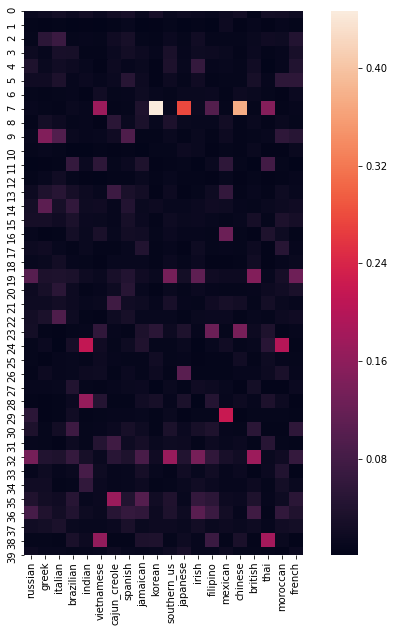

In [239]:
# Визуализируйте матрицу
plot_matrix(compute_topic_cuisine_matrix(ldamodel, corpus, recipes))

Чем темнее квадрат в матрице, тем больше связь этой темы с данной кухней. Мы видим, что у нас есть темы, которые связаны с несколькими кухнями. Такие темы показывают набор ингредиентов, которые популярны в кухнях нескольких народов, то есть указывают на схожесть кухонь этих народов. Некоторые темы распределены по всем кухням равномерно, они показывают наборы продуктов, которые часто используются в кулинарии всех стран. 

Жаль, что в датасете нет названий рецептов, иначе темы было бы проще интерпретировать...

### Заключение
В этом задании вы построили несколько моделей LDA, посмотрели, на что влияют гиперпараметры модели и как можно использовать построенную модель. 